<a href="https://colab.research.google.com/github/tanmaylaud/biospec/blob/main/Siamese_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# we used wandb api to log our training cycle and model stats
!pip install -q wandb

     |████████████████████████████████| 1.8MB 10.2MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 163kB 49.5MB/s 
     |████████████████████████████████| 133kB 33.9MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/CSE291C00/Stage_1_Analysis_29_tissues_Project/'

/content/drive/.shortcut-targets-by-id/1_O2YlSpkQTkWjTz-eA55kIq2rufipnHk/CSE291C00/Stage_1_Analysis_29_tissues_Project


In [4]:
import torch
import random
import numpy as np
import pandas as pd
import time
import torch.nn.functional as F
import pickle
import torch
from torch.utils.data import Dataset
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import math
import wandb
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [5]:
#defining the seed for reproducability
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
#reading the merged_stomach_tissue data. 
#in this case we are using 5 stomach tissue files.
with open('stomach_merged.pickle','rb') as f:
    merged = pickle.load(f)

In [7]:
#for each spectrum storing the data needed as a dictionary,
#grouping is done by the peptide.
grouped_spectra = {}
for d in merged.values:
  if d[3] not in grouped_spectra:
    grouped_spectra[d[3]] = []
  grouped_spectra[d[3]].append({
      'mass': d[2],
      'charge': d[1],
      'protein': d[4],
      'spectrum':d[5].toarray()
  })  

In [ ]:
# contains a list of peptides, where each peptide consists of the spectrums associated with it.
g_s = []
for g in grouped_spectra:
  g_s.append((g, grouped_spectra[g]))
 

In [ ]:
#creating a dataframe
#peptide column contains the peptide name and raw contains multiple spectrums of the peptide.
spec = pd.DataFrame(g_s,columns=['peptide','raw'])

In [ ]:
data = spec[spec.apply(lambda x: len(x['raw'])>1,axis=1)]

In [ ]:
#processing the data for siamese network
#y label has values 0 or 1. y = 1 means similar candidates (from the same peptide).
#y = 0 means contrast candidates (from different peptides)
processed = []

for i, row in enumerate(data.values):

    raw = row[1]
    peptide1 = row[0]

    #if peptide contains > 4 spectrums then find similar candidates by taking two pairs.
    if len(raw) > 4:
      for i in range(0,3,2):
        similar_candidates = raw[i:i+2]
        processed.append({'x':similar_candidates,
                      'y': 1,
                      'peptide1': peptide1,
                      'peptide2': peptide1,
                     })
    # taking a pair of similar spectrums as candidates
    else:
      similar_candidates = random.sample(raw,2)
      processed.append({'x':similar_candidates,
                      'y': 1,
                      'peptide1': peptide1,
                      'peptide2': peptide1,
                     })
    # taking 6 pairs of contrast candidates
    for i in range(0,6):
      current_candidate = random.sample(raw,1)[0]
      contrast_peptide = random.sample(list(data.values),1)

      contrast_candidate = random.sample(contrast_peptide[0][1],1)[0]
      processed.append({'x':[current_candidate,contrast_candidate],
                        'y' : 0,
                        'peptide1': peptide1,
                        'peptide2':contrast_peptide[0][0]
                        })


In [ ]:
#writing the processed data into a pickle file for usage. 
with open('processed_sia.pickle','wb') as f:
  pickle.dump(processed, f)

In [8]:
#loading processed data
with open('processed_sia.pickle','rb') as f:
  processed = pickle.load(f)

In [9]:
# Lets look at the ratio of positive to negative samples
pd.DataFrame(processed)['y'].value_counts()

0    110844
1     34400
Name: y, dtype: int64

In [10]:
#using gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
#to get the dataset by index from the processed data.
class SpectrumDataset(Dataset):
  def __init__(self, processed):
    self.data = processed
    self.data_len = len(processed)
  
  def __len__(self):
    return self.data_len

  def __getitem__(self,idx):
    row = self.data[idx]
    return row

In [12]:
dataset = SpectrumDataset(processed)

In [13]:
dataset.__len__()

145244

In [14]:
# spliting the data into train, test, validation sets
train_data,valid_data,test_data = torch.utils.data.random_split(dataset,[int(dataset.__len__()*0.8),int(dataset.__len__()*0.1),int(dataset.__len__()*0.1)+1])

In [15]:
#sample of the data used in the model.
train_data.__getitem__(10)

{'peptide1': '-.[43.006]SDGLAHLDNLK.-',
 'peptide2': '-.[43.006]SDGLAHLDNLK.-',
 'x': [{'charge': 2,
   'mass': 1225.62,
   'protein': 'sp|P02042|HBD_HUMAN',
   'spectrum': array([[0., 0., 0., ..., 0., 0., 0.]])},
  {'charge': 2,
   'mass': 1225.62,
   'protein': 'sp|P02042|HBD_HUMAN',
   'spectrum': array([[0., 0., 0., ..., 0., 0., 0.]])}],
 'y': 1}

In [16]:
#preparing data for training with dataloaders and a batch of 256.
BATCH_SIZE = 256
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

## Model Encoder

In [53]:

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    
    self.convnet = nn.Sequential(nn.Conv1d(1, 32, 100, 20), nn.PReLU(),
                                     nn.MaxPool1d(50, stride=2),
                                     nn.Conv1d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool1d(2, stride=2))
    
    self.linear = nn.Linear(640+2,256)

  def forward(self,spectrum, mass, charge):
    spectrum = spectrum.to(device)

    convolved  = self.convnet(spectrum.float())
    
    mass = torch.log(mass.float().to(device).unsqueeze(-1))
    charge = torch.log(charge.float().to(device).unsqueeze(-1))
    
    convolved = convolved.view(convolved.size()[0],-1)

    concatenated = torch.cat([convolved, mass ,charge],dim=-1)
  
    return self.linear(concatenated)

class SiameseNetwork(nn.Module):
  def __init__(self, encoder):
    super(SiameseNetwork,self).__init__()
    self.encoder = encoder

  def forward(self,x):
    x1, x2 = x
    
    x1 = self.encoder(x1['spectrum'],x1['mass'],x1['charge'])
    x2 = self.encoder(x2['spectrum'],x2['mass'],x2['charge'])

    return x1, x2

class ContrastiveLoss(nn.Module):
    """
    Contrastive loss using Cosine Embedding Loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == -1 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
        self.loss = torch.nn.CosineEmbeddingLoss(margin=margin, size_average=None, reduce=None, reduction='mean')

    def forward(self, output1, output2, target):
        target = target.masked_fill(target==0,-1)
        return self.loss(output1,output2,target)

## Training the model

In [54]:
enc = Encoder()
model = SiameseNetwork(enc).to(device)

In [55]:
# initialize model paramaters
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

model.apply(init_weights)

The model has 178,146 trainable parameters


SiameseNetwork(
  (encoder): Encoder(
    (convnet): Sequential(
      (0): Conv1d(1, 32, kernel_size=(100,), stride=(20,))
      (1): PReLU(num_parameters=1)
      (2): MaxPool1d(kernel_size=50, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
      (4): PReLU(num_parameters=1)
      (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (linear): Linear(in_features=642, out_features=256, bias=True)
  )
)

In [20]:
# initialize optimizer
optimizer = optim.Adam(model.parameters())

In [30]:
# initialize wandb for viewing the loss curves.
N_EPOCHS = 50
#CLIP = 1
RUN_NAME= 'siamese_contrast_8'
CONTRASTIVE_MARGIN = 0
MODEL_NAME = RUN_NAME+'.pt'
def init_wandb(model,config,run_name):
    wandb.init(project="cse291c00_siamese",name=run_name,config=config)
    #try:
    #    wandb.watch(model)
    #except:
    #    print("Model already under watch!")

config = dict({
    'model_type':'siamese_32',
    'seed':SEED,
    'n_epochs':N_EPOCHS,
    #'clip':CLIP,
    'batch size': BATCH_SIZE,
    'trainable params': count_parameters(model),
    'contrastive_margin': CONTRASTIVE_MARGIN
})

In [31]:
def train(model, optimizer, loss_fn, train_dataloader, device):
  model.train()
  epoch_loss = 0.0
  for i, batch in enumerate(train_dataloader):

    optimizer.zero_grad()
    x, y_true = batch['x'], batch['y'].to(device)
    x1_embedded, x2_embedded = model(x)
    
    loss = loss_fn(x1_embedded, x2_embedded, y_true)
      
    loss.backward()
    
    optimizer.step()
      
    epoch_loss += loss.item()
  return epoch_loss/len(train_dataloader)

In [32]:
def evaluate(model, loss_fn, valid_dataloader, device):
    
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    
    for i, batch in enumerate(valid_dataloader):

      x,y_true = batch['x'], batch['y'].to(device)
      x1_embedded, x2_embedded = model(x)
      loss = loss_fn(x1_embedded, x2_embedded, y_true)
        
      epoch_loss += loss.item()
    return epoch_loss/len(valid_dataloader)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
# initialize loss margin
contrastive_loss = ContrastiveLoss(margin=CONTRASTIVE_MARGIN)

In [ ]:
# running the training of the data.
# reporting the epoch train and validation loss 
N_EPOCHS = 50
best_valid_loss = float('inf')
init_wandb(model,config,RUN_NAME)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, optimizer, contrastive_loss, train_dataloader, device)
    valid_loss = evaluate(model, contrastive_loss, valid_dataloader, device)
    # logging into wandb for plots
    wandb.log({'epoch_loss':{
                    'epoch':epoch,
                    'train':{
                        'loss':train_loss
                    },
                    'eval':{
                        'loss':valid_loss
                    }
             }})
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # saving the model with best validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss}')
    print(f'\t Val. Loss: {valid_loss}')

_runtime,406
_timestamp,1620702794
_step,49


_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Epoch: 01 | Time: 0m 8s
	Train Loss: 0.36959833011753235
	 Val. Loss: 0.3411560424587183
Epoch: 02 | Time: 0m 7s
	Train Loss: 0.3262015195144956
	 Val. Loss: 0.3192967406490393
Epoch: 03 | Time: 0m 7s
	Train Loss: 0.2969371999084687
	 Val. Loss: 0.31841364712045905
Epoch: 04 | Time: 0m 7s
	Train Loss: 0.27636001065439064
	 Val. Loss: 0.2768283371339765
Epoch: 05 | Time: 0m 7s
	Train Loss: 0.2674340436374563
	 Val. Loss: 0.2564349519579034
Epoch: 06 | Time: 0m 7s
	Train Loss: 0.25786905565057033
	 Val. Loss: 0.2527088423569997
Epoch: 07 | Time: 0m 7s
	Train Loss: 0.2579579987124199
	 Val. Loss: 0.2515967415090193
Epoch: 08 | Time: 0m 7s
	Train Loss: 0.2549144185849749
	 Val. Loss: 0.2647904975895296
Epoch: 09 | Time: 0m 7s
	Train Loss: 0.25102599601913655
	 Val. Loss: 0.25089769248376814
Epoch: 10 | Time: 0m 7s
	Train Loss: 0.24980242294361937
	 Val. Loss: 0.24641836526101096
Epoch: 11 | Time: 0m 7s
	Train Loss: 0.24905099499855798
	 Val. Loss: 0.24792889387984024
Epoch: 12 | Time: 0m 7

## Testing the Model

In [35]:
# loading the model and running evaluation on test data.
model.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(model, contrastive_loss, test_dataloader, device)

print(f'Test Loss: {test_loss}')

Test Loss: 0.238095364026856


In [36]:
# finding the cosine similarity for the pairs of spectrums 
# considering 256 pairs of samples
test = next(iter(test_dataloader))
with torch.no_grad():
  emb  = model(test['x'])

cos = torch.nn.CosineSimilarity(dim=-1)

# storing it against the y-value for comparison
pd.DataFrame([cos(emb[0],emb[1]),test['y']]).T

,0,1
0,"tensor(-0.1862, device='cuda:0')",tensor(1)
1,"tensor(0.6873, device='cuda:0')",tensor(1)
2,"tensor(0.0911, device='cuda:0')",tensor(0)
3,"tensor(-0.2613, device='cuda:0')",tensor(0)
4,"tensor(0.8905, device='cuda:0')",tensor(0)
...,...,...
251,"tensor(-0.1500, device='cuda:0')",tensor(0)
252,"tensor(0.1034, device='cuda:0')",tensor(0)
253,"tensor(-0.2866, device='cuda:0')",tensor(0)
254,"tensor(-0.1081, device='cuda:0')",tensor(1)


In [37]:
# calculation TPs and FPs for the 256 pair of samples ,i.e one batch
cos = torch.nn.CosineSimilarity(dim=-1)
batch_pred = []
batch_true = []
for i, batch in enumerate(test_dataloader):
  with torch.no_grad():
    emb  = model(batch['x'])
    batch_pred.append(cos(emb[0],emb[1]).cpu())
    batch_true.append(batch['y'].cpu())


In [38]:
y_pred = torch.stack(batch_pred[:-1]).view(56*256).numpy()
y_pred

array([-0.04971631,  0.9790185 , -0.13740836, ..., -0.12182835,
        0.3146506 , -0.17499034], dtype=float32)

In [39]:
y_true = torch.stack(batch_true[:-1]).view(56*256).numpy()
y_true

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
 # storing the prediction and true values in a dataframe
 df = pd.DataFrame([y_pred,y_true]).T
 df.columns =['y_pred','y_true']

In [41]:
# ploting the ROC and precision-recall curve for the samples
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,precision_recall_curve
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#using matplotlib
def get_plots(df):
  fpr, tpr, thresholds = roc_curve(y_true=df['y_true'], y_score=df['y_pred'])
  plt.figure()
  plt.plot(fpr,tpr)
  plt.grid(True)
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  precision, recall, thresholds = precision_recall_curve(y_true=df['y_true'], probas_pred=df['y_pred'])
  plt.figure()
  plt.plot(recall,precision)
  plt.grid(True)
  plt.ylabel('Precision')
  plt.xlabel('Recall')

#using plotly for interactive plot to get threshold
def get_plotly_plots(df):
  fpr, tpr, thresholds = roc_curve(y_true=df['y_true'], y_score=df['y_pred'])

  plot_data = pd.DataFrame([fpr,tpr,thresholds]).T
  plot_data.columns = ["fpr","tpr","thresholds"]
  fig1 = go.Scatter(x= plot_data['fpr'], y=plot_data['tpr'], mode='lines', text= plot_data['thresholds'])
  
 
  precision, recall, thresholds = precision_recall_curve(y_true=df['y_true'], probas_pred=df['y_pred'])
  plot_data = pd.DataFrame([precision,recall,thresholds]).T
  plot_data.columns = ["Precision","Recall","Thresholds"]
  fig2 = px.line(plot_data,y="Precision",x="Recall",hover_name="Thresholds")
  fig2 = go.Scatter(x= plot_data['Recall'], y=plot_data['Precision'], mode='lines', text= plot_data['Thresholds'])

  return fig1, fig2

#to get precision, recall and confusion matrix
def get_confusion_matrix(df, threshold=0.0):
  def thres(y):
    if y <= threshold:
      return 0
    return 1  
  df['y_pred_thres'] = df['y_pred'].apply(thres)
  print(classification_report(y_true=df['y_true'],y_pred=df['y_pred_thres']))
  print(confusion_matrix(y_true=df['y_true'],y_pred=df['y_pred_thres']))



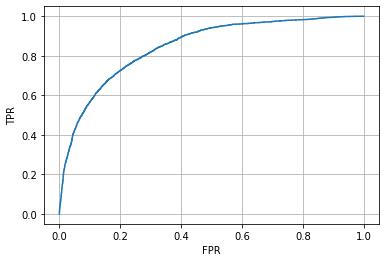

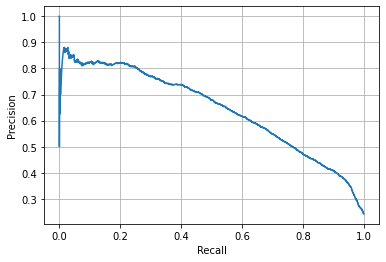

In [42]:
get_plots(df)

In [43]:
roc, pr = get_plotly_plots(df)
fig = go.Figure(roc)
fig.update_layout(title='ROC Curve',
                   xaxis_title='FPR',
                   yaxis_title='TPR')

In [44]:
fig = go.Figure(pr)
fig.update_layout(title='Precision Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision')

In [45]:
# threshold = 0
get_confusion_matrix(df, 0.0)

              precision    recall  f1-score   support

         0.0       0.96      0.56      0.71     10925
         1.0       0.39      0.92      0.55      3411

    accuracy                           0.64     14336
   macro avg       0.67      0.74      0.63     14336
weighted avg       0.82      0.64      0.67     14336

[[6117 4808]
 [ 283 3128]]


In [46]:
# threshold = 0.13
get_confusion_matrix(df, 0.13)

              precision    recall  f1-score   support

         0.0       0.94      0.64      0.76     10925
         1.0       0.43      0.87      0.57      3411

    accuracy                           0.69     14336
   macro avg       0.68      0.75      0.67     14336
weighted avg       0.82      0.69      0.72     14336

[[6989 3936]
 [ 460 2951]]


### Let's create a baseline based on raw spectrum

In [47]:
batch_raw_pred = []
batch_raw_true = []
for i, batch in enumerate(test_dataloader):
  with torch.no_grad():
    s1 , s2 = batch['x'][0]['spectrum'], batch['x'][1]['spectrum']
    batch_raw_pred.append(cos(s1,s2).cpu())
    batch_raw_true.append(batch['y'].cpu())
y_raw_pred = torch.stack(batch_raw_pred[:-1]).view(56*256).numpy()
y_raw_pred

array([0.00195195, 0.07120799, 0.02322553, ..., 0.00051845, 0.04162021,
       0.13417743])

In [49]:
# Dataframe storing cosine similarity of raw spectrum and ground truth
df_raw = pd.DataFrame([y_raw_pred,y_true]).T
df_raw.columns =['y_pred','y_true']
df_raw

,y_pred,y_true
0,0.001952,0.0
1,0.071208,0.0
2,0.023226,0.0
3,0.005485,1.0
4,0.010611,0.0
...,...,...
14331,0.124869,0.0
14332,0.006872,1.0
14333,0.000518,0.0
14334,0.041620,0.0


In [50]:
# ROC and PR curve for Baseline and our Embeddings
roc_raw,pr_raw = get_plotly_plots(df_raw)
roc.update({"name":"Cosine on Embedding"})
roc_raw.update({"name":"Cosine on Spectrum"})
fig = go.Figure([roc_raw,roc])
fig.update_layout(title='ROC Curve',
                   xaxis_title='FPR',
                   yaxis_title='TPR',
                  autosize=False)

In [51]:
pr.update({"name":"Cosine on Embedding"})
pr_raw.update({"name":"Cosine on Spectrum"})
fig = go.Figure([pr_raw,pr])
fig.update_layout(title='Precision Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision',
                  autosize=False)

In [52]:
# Results for Baseline
get_confusion_matrix(df_raw, threshold=0.6)

              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86     10925
         1.0       0.27      0.01      0.03      3411

    accuracy                           0.76     14336
   macro avg       0.52      0.50      0.44     14336
weighted avg       0.65      0.76      0.66     14336

[[10803   122]
 [ 3365    46]]


In [ ]:
stacked = torch.stack((emb[0],emb[1])).view(512,256)

In [ ]:
# computing TSNE with pca on sample spectrum embeddings
X = stacked.cpu().numpy()
tsne = TSNE(n_components=3, n_jobs=-1,init='pca')
X_embedded = tsne.fit_transform(X)
X_embedded.shape

(512, 3)

In [ ]:
# to get same colors for samples with same peptides.
lb = LabelEncoder()
colors = lb.fit_transform(test['peptide1']+test['peptide2'])

In [ ]:
embd = X_embedded.T

In [ ]:
df = pd.DataFrame([embd[0],embd[1],embd[2],lb.fit_transform(test['peptide1']+test['peptide2']), test['peptide1']+test['peptide2']]).T
df.columns = ['x1','x2', 'x3', 'color','peptide']
df

,x1,x2,x3,color,peptide
0,5.8862,26.5575,16.2605,247,K.TLYGRPNWDNEFK.T
1,-64.1799,17.0371,13.7489,426,"R.{96.022}T(C,57.021)EEHQL(C,57.021)VVAVLPHILD..."
2,-9.95116,24.606,-12.0556,266,K.[-17.027]QYNDGLSHFVISSVSPTRY.E
3,-20.7188,-33.3773,-29.7109,191,K.GDTANEIGQVLHFENVK.D
4,48.3771,32.3761,53.7846,237,"K.S(C,57.021)ETDALINFFAK.S"
...,...,...,...,...,...
507,20.4001,-39.9609,-62.8976,149,"F.S(C,57.021)SV(M,15.995)HEALHNHYTQK.S"
508,28.6559,-53.5808,13.0883,53,"-.IS(M,15.995)PDFDLHLK.-"
509,15.2789,31.0676,42.1096,362,"R.LDLAGRDLTDYL(M,15.994)K.I"
510,6.41785,55.9785,34.5931,204,K.ITFRPDSADGMLL.Y


In [ ]:
# computing count to get peptides with 2 or more spectrums
count = {}
filtered = set()
for d in df['peptide']:
  if d not in count:
    count[d]=0
  count[d]+=1
  if count[d]>=2:
    filtered.add(d)


In [ ]:
df['filter']  = df['peptide'].apply(lambda x : x in filtered)

In [ ]:
# For 256 pair of samples
px.scatter(df[df['filter']],
           x='x1',
           y='x2',
           #z='x3',
           hover_data=['peptide'],
           #marker_color = np.concatenate((lb.transform(x1_label[:200]),lb.transform(x2_label[:200]))),
           color = 'peptide'
          )